# Analyze spherical harmonics

In [1]:
import warnings
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Load our subset of cells

In [2]:
df = pd.read_csv("../data/mitocells.csv")
df.set_index(df['CellId'].astype(int), inplace=True)
print(f'Number of cells: {len(df)}')
print(f'Number of columns: {len(df.columns)}')

emmbed_cols = [
    'cell_height', 'cell_surface_area', 'cell_volume', #'cell_stage',
    'nuclear_height', 'nuclear_surface_area', 'nuclear_volume',
    # 'shape_mode_1_height', 'shape_mode_2_volume',
    # 'shape_mode_3_major_tilt', 'shape_mode_4_minor_tilt',
    # 'shape_mode_5_elongation', 'shape_mode_6_bean-ness',
    # 'shape_mode_7_pear-ness', 'shape_mode_8_wedge',
]
print(f"There are {len(emmbed_cols)} columns")

df[emmbed_cols].shape

df_fillna = df[emmbed_cols].fillna(0)
print(df_fillna.shape)

Number of cells: 10381
Number of columns: 79
There are 6 columns
(10381, 6)


In [3]:
shapes = pd.read_csv("../data/shape_coefficients.csv", index_col=-1)
shapes.index = shapes.index.astype(int)
print(shapes.shape)

(5700, 578)


In [4]:
shapes.head()

,shcoeffs_L0M0C,shcoeffs_L0M1C,shcoeffs_L0M2C,shcoeffs_L0M3C,shcoeffs_L0M4C,shcoeffs_L0M5C,shcoeffs_L0M6C,shcoeffs_L0M7C,shcoeffs_L0M8C,shcoeffs_L0M9C,...,shcoeffs_L16M7S,shcoeffs_L16M8S,shcoeffs_L16M9S,shcoeffs_L16M10S,shcoeffs_L16M11S,shcoeffs_L16M12S,shcoeffs_L16M13S,shcoeffs_L16M14S,shcoeffs_L16M15S,shcoeffs_L16M16S
CellId,,,,,,,,,,,,,,,,,,,,,
594586,71.497842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.022096,-0.152563,0.210930,0.016170,0.165243,-0.081148,0.042660,0.062661,0.137631,-0.133696
234365,84.726230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.140338,-0.063409,-0.059273,0.046387,0.027333,-0.088476,-0.079978,0.091266,0.089168,0.058997
834625,63.268344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.140902,-0.103120,0.140930,0.035014,0.084632,-0.062862,0.043393,-0.015708,-0.199038,-0.160911
277287,91.080179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.072385,-0.052856,0.015195,0.048991,-0.096000,-0.053973,-0.024208,0.033526,0.033827,-0.013378
908507,60.606058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.195217,0.034919,0.127609,0.069609,-0.075819,-0.036343,0.111201,-0.152928,0.035372,0.219563


In [5]:
# get rid of 0-only columns
select = ~(shapes.sum(axis=0) == 0)
shapes = shapes.loc[:, select]
shapes.head()

,shcoeffs_L0M0C,shcoeffs_L1M0C,shcoeffs_L1M1C,shcoeffs_L2M0C,shcoeffs_L2M1C,shcoeffs_L2M2C,shcoeffs_L3M0C,shcoeffs_L3M1C,shcoeffs_L3M2C,shcoeffs_L3M3C,...,shcoeffs_L16M7S,shcoeffs_L16M8S,shcoeffs_L16M9S,shcoeffs_L16M10S,shcoeffs_L16M11S,shcoeffs_L16M12S,shcoeffs_L16M13S,shcoeffs_L16M14S,shcoeffs_L16M15S,shcoeffs_L16M16S
CellId,,,,,,,,,,,,,,,,,,,,,
594586,71.497842,-0.208950,-0.198543,-9.852845,-4.543054,5.128953,-0.358528,0.994330,-0.345336,6.585218,...,-0.022096,-0.152563,0.210930,0.016170,0.165243,-0.081148,0.042660,0.062661,0.137631,-0.133696
234365,84.726230,-0.313825,2.157537,-11.378481,-3.142546,6.225584,-4.036556,0.431353,1.424568,-0.382067,...,0.140338,-0.063409,-0.059273,0.046387,0.027333,-0.088476,-0.079978,0.091266,0.089168,0.058997
834625,63.268344,-4.780371,0.782874,-17.145371,6.982062,10.844402,0.013442,1.253234,-0.671734,2.729649,...,0.140902,-0.103120,0.140930,0.035014,0.084632,-0.062862,0.043393,-0.015708,-0.199038,-0.160911
277287,91.080179,-0.888658,0.318489,-21.037472,-2.173427,2.502297,1.031830,-0.949930,2.229775,1.218511,...,0.072385,-0.052856,0.015195,0.048991,-0.096000,-0.053973,-0.024208,0.033526,0.033827,-0.013378
908507,60.606058,1.778224,-2.044136,-21.017156,-1.043737,7.820436,-1.950074,0.518404,-1.074633,0.428935,...,-0.195217,0.034919,0.127609,0.069609,-0.075819,-0.036343,0.111201,-0.152928,0.035372,0.219563


In [6]:
shapes.to_csv(f'../data/shape_coefficients_ncells-{len(shapes)}_cleaned.csv')

## Make PCA components on 3D shape coefficients

In [7]:
# First need to rescale columns
std_transformer = StandardScaler()
shapes_std = shapes.copy()
shapes_std.loc[:, :] = std_transformer.fit_transform(shapes_std.loc[:, :])

# Actual PCA, down to 40 components
n_compo = 40
pca = PCA(n_components=n_compo)
trans = pca.fit_transform(shapes_std)
col_names = [f'PC{x+1}' for x in range(n_compo)]
shapes_trans = pd.DataFrame(trans, columns=col_names)
shapes_trans.index = shapes.index

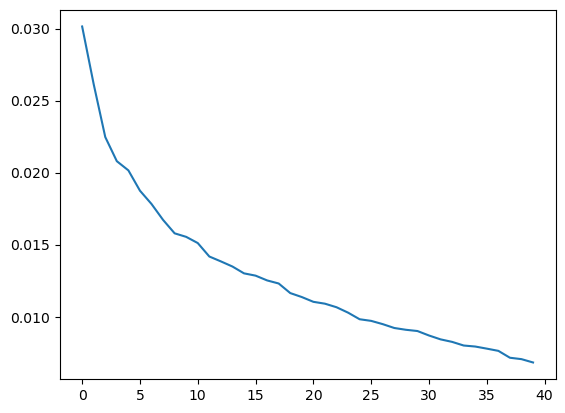

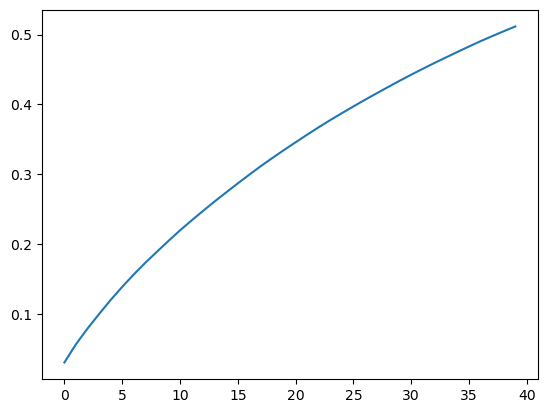

In [8]:
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.figure()
plt.plot(pca.explained_variance_ratio_.cumsum())

In [9]:
shapes.head()

,shcoeffs_L0M0C,shcoeffs_L1M0C,shcoeffs_L1M1C,shcoeffs_L2M0C,shcoeffs_L2M1C,shcoeffs_L2M2C,shcoeffs_L3M0C,shcoeffs_L3M1C,shcoeffs_L3M2C,shcoeffs_L3M3C,...,shcoeffs_L16M7S,shcoeffs_L16M8S,shcoeffs_L16M9S,shcoeffs_L16M10S,shcoeffs_L16M11S,shcoeffs_L16M12S,shcoeffs_L16M13S,shcoeffs_L16M14S,shcoeffs_L16M15S,shcoeffs_L16M16S
CellId,,,,,,,,,,,,,,,,,,,,,
594586,71.497842,-0.208950,-0.198543,-9.852845,-4.543054,5.128953,-0.358528,0.994330,-0.345336,6.585218,...,-0.022096,-0.152563,0.210930,0.016170,0.165243,-0.081148,0.042660,0.062661,0.137631,-0.133696
234365,84.726230,-0.313825,2.157537,-11.378481,-3.142546,6.225584,-4.036556,0.431353,1.424568,-0.382067,...,0.140338,-0.063409,-0.059273,0.046387,0.027333,-0.088476,-0.079978,0.091266,0.089168,0.058997
834625,63.268344,-4.780371,0.782874,-17.145371,6.982062,10.844402,0.013442,1.253234,-0.671734,2.729649,...,0.140902,-0.103120,0.140930,0.035014,0.084632,-0.062862,0.043393,-0.015708,-0.199038,-0.160911
277287,91.080179,-0.888658,0.318489,-21.037472,-2.173427,2.502297,1.031830,-0.949930,2.229775,1.218511,...,0.072385,-0.052856,0.015195,0.048991,-0.096000,-0.053973,-0.024208,0.033526,0.033827,-0.013378
908507,60.606058,1.778224,-2.044136,-21.017156,-1.043737,7.820436,-1.950074,0.518404,-1.074633,0.428935,...,-0.195217,0.034919,0.127609,0.069609,-0.075819,-0.036343,0.111201,-0.152928,0.035372,0.219563


In [10]:
shapes_trans.to_csv(f'../data/shape_coefficients_cleaned_ncells-{len(shapes)}_PCA_ncompo-{n_compo}.csv')

In [11]:
for col in shapes.columns[:20]:
    print(col)

shcoeffs_L0M0C
shcoeffs_L1M0C
shcoeffs_L1M1C
shcoeffs_L2M0C
shcoeffs_L2M1C
shcoeffs_L2M2C
shcoeffs_L3M0C
shcoeffs_L3M1C
shcoeffs_L3M2C
shcoeffs_L3M3C
shcoeffs_L4M0C
shcoeffs_L4M1C
shcoeffs_L4M2C
shcoeffs_L4M3C
shcoeffs_L4M4C
shcoeffs_L5M0C
shcoeffs_L5M1C
shcoeffs_L5M2C
shcoeffs_L5M3C
shcoeffs_L5M4C


## On raw shape coeffs

In [12]:
merged = pd.concat([df_fillna, shapes], axis=1, join='inner')
print(merged.shape)

(5700, 295)


In [13]:
merged.head()

,cell_height,cell_surface_area,cell_volume,nuclear_height,nuclear_surface_area,nuclear_volume,shcoeffs_L0M0C,shcoeffs_L1M0C,shcoeffs_L1M1C,shcoeffs_L2M0C,...,shcoeffs_L16M7S,shcoeffs_L16M8S,shcoeffs_L16M9S,shcoeffs_L16M10S,shcoeffs_L16M11S,shcoeffs_L16M12S,shcoeffs_L16M13S,shcoeffs_L16M14S,shcoeffs_L16M15S,shcoeffs_L16M16S
CellId,,,,,,,,,,,,,,,,,,,,,
287799,7.041645,1710.175587,1920.040764,5.308317,582.365722,582.803541,59.268071,1.908924,-3.083403,-19.597354,...,-0.066403,0.039511,0.136770,0.059721,0.117506,-0.088175,-0.259220,0.096930,-0.000529,-0.121432
786516,11.266632,1968.251082,2000.503875,7.908309,572.577865,572.753122,60.033320,4.629448,-2.572601,-13.259347,...,0.021323,0.000248,0.098959,0.033786,0.030538,-0.074200,-0.137614,-0.098077,-0.123728,0.185707
668510,8.774973,1153.746511,1226.630482,4.983318,407.217077,356.181523,54.939767,-0.521396,-0.562739,-13.952230,...,0.054802,-0.237029,0.148284,-0.109349,-0.098953,-0.029862,0.029952,0.064577,-0.008893,-0.058246
369702,9.424971,1620.864331,1844.169951,6.824979,545.021646,530.434563,61.323014,4.960705,-4.634186,-15.221691,...,-0.074807,0.167699,0.153920,0.009832,-0.033410,-0.096394,-0.003489,-0.331325,0.039512,0.178485
293621,7.041645,1889.854342,2519.822584,4.658319,681.300530,717.922879,64.827406,1.619154,1.158490,-25.674130,...,-0.192215,-0.087320,0.019012,-0.034256,0.087377,0.110874,-0.118473,-0.176645,0.129686,-0.026261


In [14]:
df_std = merged.copy()
std_transformer = StandardScaler()
df_std.loc[:, :] = std_transformer.fit_transform(df_std.loc[:, :])

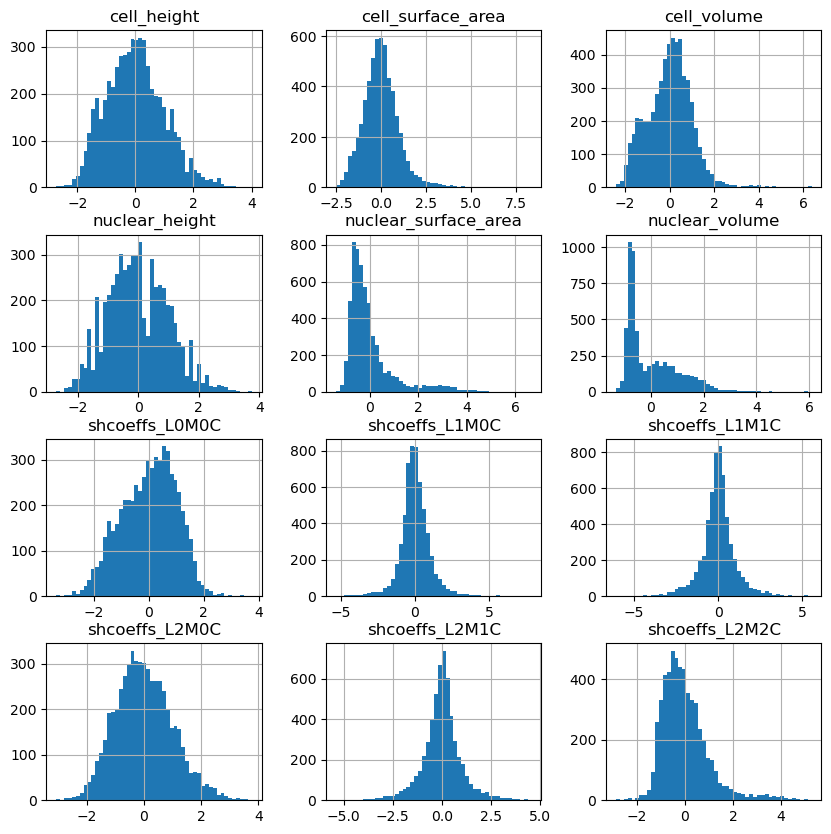

In [15]:
df_std.iloc[:, :12].hist(bins=50, figsize=(10, 10));

In [16]:
reducer = umap.UMAP(random_state=0)
embedding = reducer.fit_transform(df_std)
embedding.shape

(5700, 2)

In [17]:
# For the visualization
marker = '.'
size_points = 10

In [18]:
y = df.loc[df_std.index, 'cell_stage']
import matplotlib.cm as cm

def make_colors(y, cmap_name='tab10', as_series=True):
    # make a cohort-wide cmap
    cmap = cm.get_cmap(cmap_name).colors
    # make color mapper
    # series to sort by decreasing order
    uniq = pd.Series(y).value_counts().index
    n_colors = len(cmap)
    labels_color_mapper = {x: cmap[i % n_colors] for i, x in enumerate(uniq)}
    # make list of colors
    labels_colors = [labels_color_mapper[x] for x in y]
    if as_series:
        labels_colors = pd.Series(labels_colors)
    return labels_colors


In [19]:
y.value_counts()

M0               1651
M4M5             1648
M1M2             1230
M6M7_complete     659
M3                512
Name: cell_stage, dtype: int64

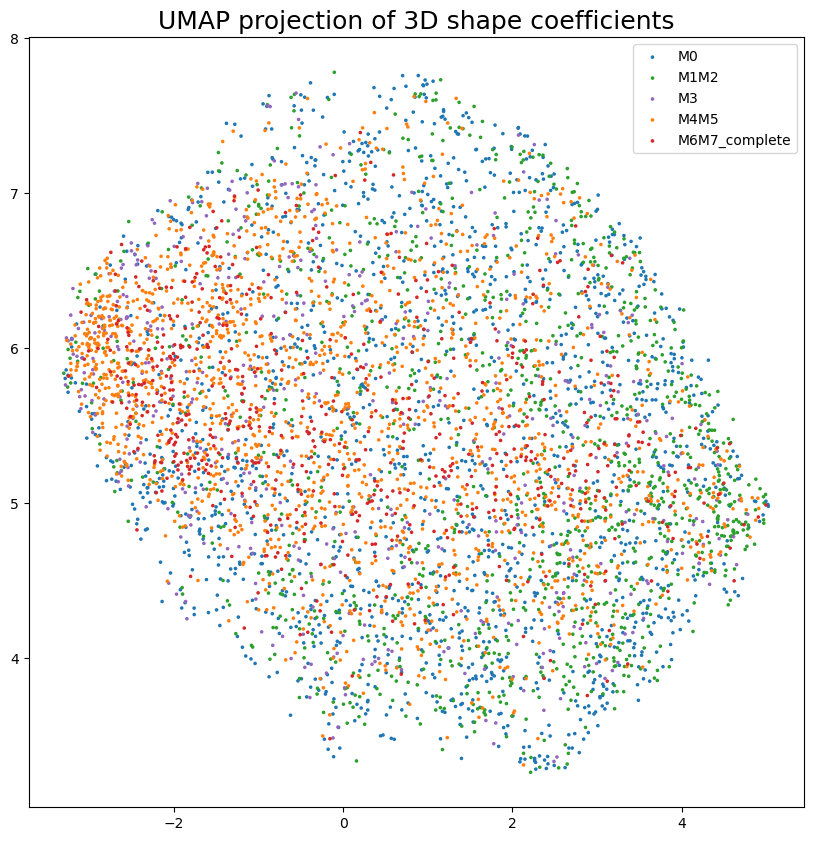

In [20]:
colors = make_colors(y, cmap_name='tab10')
fig, ax = plt.subplots(figsize=[10,10])
for y_class in np.unique(y):
    select = y.values == y_class
    ax.scatter(embedding[select, 0], embedding[select, 1], c=colors[select], marker=marker, s=size_points, label=y_class)
plt.legend()
title = "UMAP projection of 3D shape coefficients"
plt.title(title, fontsize=18);

## On first raw shape coeff

In [21]:
merged = pd.concat([df_fillna, shapes.iloc[:, :15]], axis=1, join='inner')
print(merged.shape)

(5700, 21)


In [22]:
merged.head()

,cell_height,cell_surface_area,cell_volume,nuclear_height,nuclear_surface_area,nuclear_volume,shcoeffs_L0M0C,shcoeffs_L1M0C,shcoeffs_L1M1C,shcoeffs_L2M0C,...,shcoeffs_L2M2C,shcoeffs_L3M0C,shcoeffs_L3M1C,shcoeffs_L3M2C,shcoeffs_L3M3C,shcoeffs_L4M0C,shcoeffs_L4M1C,shcoeffs_L4M2C,shcoeffs_L4M3C,shcoeffs_L4M4C
CellId,,,,,,,,,,,,,,,,,,,,,
287799,7.041645,1710.175587,1920.040764,5.308317,582.365722,582.803541,59.268071,1.908924,-3.083403,-19.597354,...,6.687349,-0.693974,1.090243,0.550042,1.208344,6.920410,-0.819862,-3.161066,-1.606500,1.962744
786516,11.266632,1968.251082,2000.503875,7.908309,572.577865,572.753122,60.033320,4.629448,-2.572601,-13.259347,...,11.966451,-1.773546,-0.522542,-1.105666,0.567232,2.931543,7.161570,-1.176152,0.733446,4.213648
668510,8.774973,1153.746511,1226.630482,4.983318,407.217077,356.181523,54.939767,-0.521396,-0.562739,-13.952230,...,1.377642,0.650379,-1.132823,0.853380,3.000623,2.713709,5.460529,-0.599385,-0.352589,-0.552048
369702,9.424971,1620.864331,1844.169951,6.824979,545.021646,530.434563,61.323014,4.960705,-4.634186,-15.221691,...,10.851334,-1.395010,-0.973852,0.355156,2.631471,0.846440,-2.463832,-5.360060,-1.255417,0.351778
293621,7.041645,1889.854342,2519.822584,4.658319,681.300530,717.922879,64.827406,1.619154,1.158490,-25.674130,...,2.496625,-0.665950,-0.255701,-0.810326,-1.733056,11.527796,0.454868,-1.455057,0.864900,-1.520259


In [23]:
df_std = merged.copy()
std_transformer = StandardScaler()
df_std.loc[:, :] = std_transformer.fit_transform(df_std.loc[:, :])

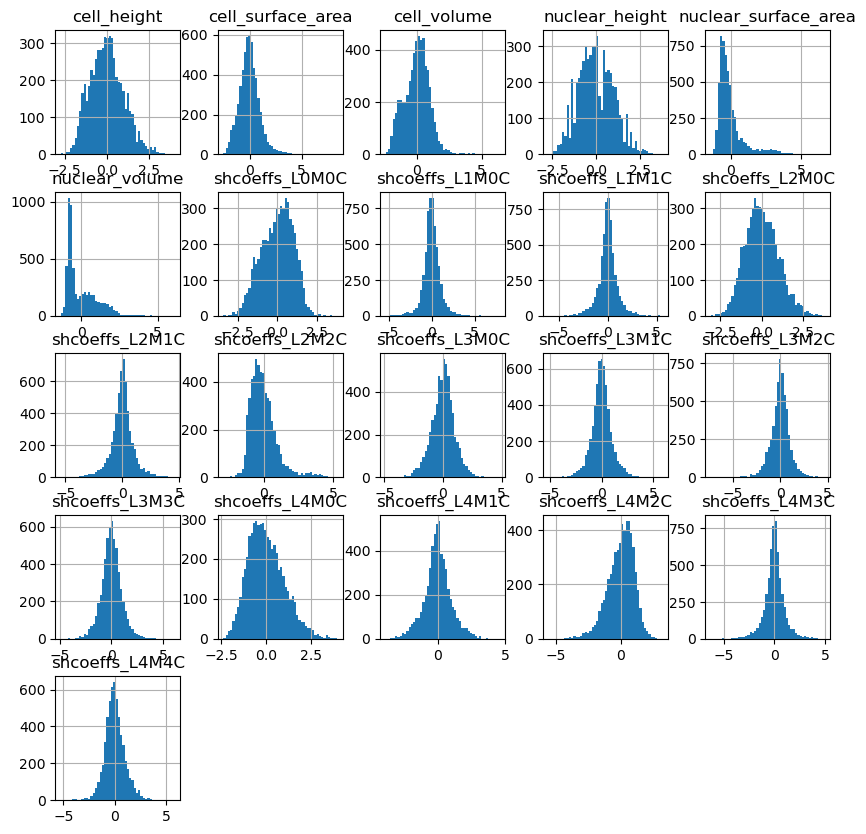

In [24]:
df_std.hist(bins=50, figsize=(10, 10));

In [25]:
reducer = umap.UMAP(random_state=0)
embedding = reducer.fit_transform(df_std)
embedding.shape

(5700, 2)

In [26]:
# For the visualization
marker = '.'
size_points = 10

In [27]:
y = df.loc[df_std.index, 'cell_stage']
import matplotlib.cm as cm

def make_colors(y, cmap_name='tab10', as_series=True):
    # make a cohort-wide cmap
    cmap = cm.get_cmap(cmap_name).colors
    # make color mapper
    # series to sort by decreasing order
    uniq = pd.Series(y).value_counts().index
    n_colors = len(cmap)
    labels_color_mapper = {x: cmap[i % n_colors] for i, x in enumerate(uniq)}
    # make list of colors
    labels_colors = [labels_color_mapper[x] for x in y]
    if as_series:
        labels_colors = pd.Series(labels_colors)
    return labels_colors


In [28]:
y.value_counts()

M0               1651
M4M5             1648
M1M2             1230
M6M7_complete     659
M3                512
Name: cell_stage, dtype: int64

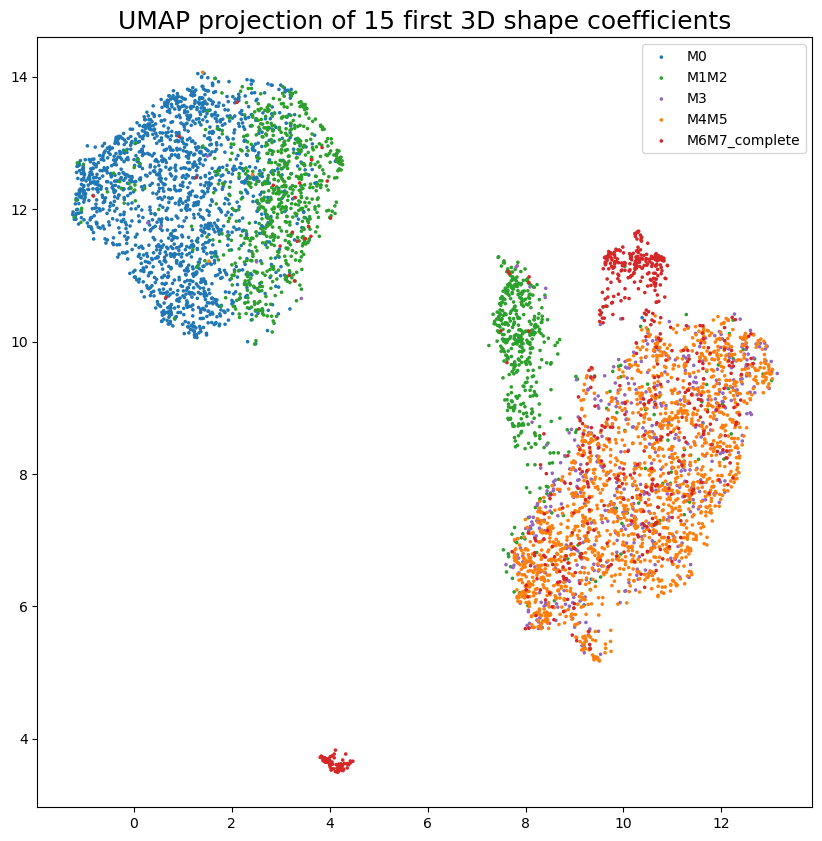

In [29]:
colors = make_colors(y, cmap_name='tab10')
fig, ax = plt.subplots(figsize=[10,10])
for y_class in np.unique(y):
    select = y.values == y_class
    ax.scatter(embedding[select, 0], embedding[select, 1], c=colors[select], marker=marker, s=size_points, label=y_class)
plt.legend()
title = "UMAP projection of 15 first 3D shape coefficients"
plt.title(title, fontsize=18);

## On PCA components of shape coeffs

In [30]:
merged = pd.concat([df_fillna, shapes_trans], axis=1, join='inner')
print(merged.shape)

(5700, 46)


In [31]:
merged.head()

,cell_height,cell_surface_area,cell_volume,nuclear_height,nuclear_surface_area,nuclear_volume,PC1,PC2,PC3,PC4,...,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40
CellId,,,,,,,,,,,,,,,,,,,,,
287799,7.041645,1710.175587,1920.040764,5.308317,582.365722,582.803541,1.653021,-3.914189,-6.924250,-5.923187,...,0.492909,2.712989,-0.059888,-2.258786,0.126183,3.249504,4.394432,1.765371,2.408045,-1.553433
786516,11.266632,1968.251082,2000.503875,7.908309,572.577865,572.753122,0.138268,9.542967,6.269232,1.349658,...,4.355089,-3.759550,-3.587771,-1.273197,-3.345707,0.671289,3.481025,1.778228,0.290303,1.456530
668510,8.774973,1153.746511,1226.630482,4.983318,407.217077,356.181523,0.325912,2.072499,0.978299,1.903874,...,0.923122,0.715537,-0.036121,-0.279642,0.842308,0.486100,0.885254,-1.041143,-0.654794,1.440557
369702,9.424971,1620.864331,1844.169951,6.824979,545.021646,530.434563,-1.145789,2.265457,1.593832,1.753772,...,-1.099411,0.086147,0.313874,1.496693,1.361085,1.661578,-3.544581,-1.136200,1.534744,-1.704615
293621,7.041645,1889.854342,2519.822584,4.658319,681.300530,717.922879,2.717286,-1.753095,-0.844210,-0.563559,...,1.719611,-0.170694,-5.315491,-0.448340,-1.756063,-1.855276,-1.035288,2.780331,1.310894,-1.053432


In [32]:
df_std = merged.copy()
std_transformer = StandardScaler()
df_std.loc[:, :] = std_transformer.fit_transform(df_std.loc[:, :])

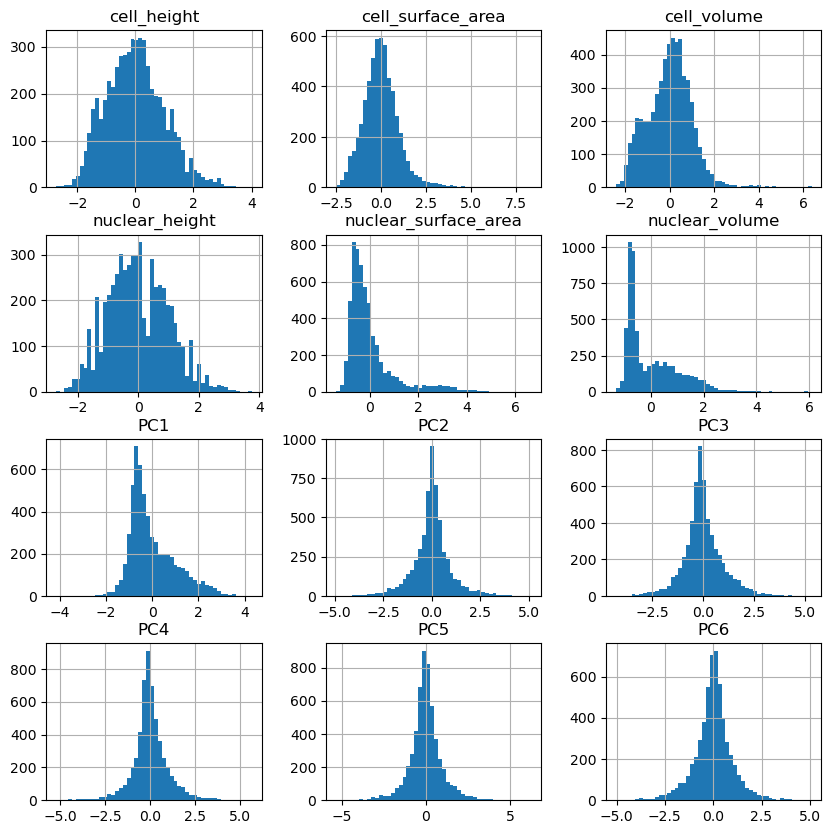

In [33]:
df_std.iloc[:, :12].hist(bins=50, figsize=(10, 10));

In [34]:
reducer = umap.UMAP(random_state=0)
embedding = reducer.fit_transform(df_std)
embedding.shape

(5700, 2)

In [35]:
# For the visualization
marker = '.'
size_points = 10

In [36]:
y = df.loc[df_std.index, 'cell_stage']
import matplotlib.cm as cm

def make_colors(y, cmap_name='tab10', as_series=True):
    # make a cohort-wide cmap
    cmap = cm.get_cmap(cmap_name).colors
    # make color mapper
    # series to sort by decreasing order
    uniq = pd.Series(y).value_counts().index
    n_colors = len(cmap)
    labels_color_mapper = {x: cmap[i % n_colors] for i, x in enumerate(uniq)}
    # make list of colors
    labels_colors = [labels_color_mapper[x] for x in y]
    if as_series:
        labels_colors = pd.Series(labels_colors)
    return labels_colors


In [37]:
y.value_counts()

M0               1651
M4M5             1648
M1M2             1230
M6M7_complete     659
M3                512
Name: cell_stage, dtype: int64

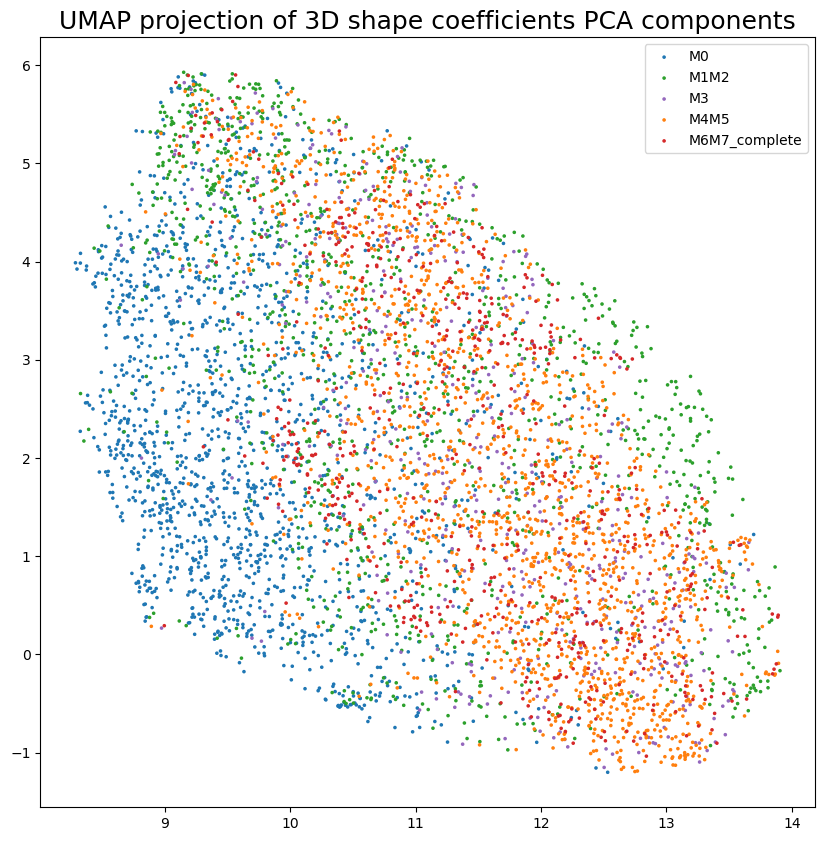

In [38]:
colors = make_colors(y, cmap_name='tab10')
fig, ax = plt.subplots(figsize=[10,10])
for y_class in np.unique(y):
    select = y.values == y_class
    ax.scatter(embedding[select, 0], embedding[select, 1], c=colors[select], marker=marker, s=size_points, label=y_class)
plt.legend()
title = "UMAP projection of 3D shape coefficients PCA components"
plt.title(title, fontsize=18);

## On first PCA components of shape coeff

In [39]:
merged = pd.concat([df_fillna, shapes_trans.iloc[:, :10]], axis=1, join='inner')
print(merged.shape)

(5700, 16)


In [40]:
merged.head()

,cell_height,cell_surface_area,cell_volume,nuclear_height,nuclear_surface_area,nuclear_volume,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
CellId,,,,,,,,,,,,,,,,
287799,7.041645,1710.175587,1920.040764,5.308317,582.365722,582.803541,1.653021,-3.914189,-6.924250,-5.923187,1.197953,-4.770944,3.344444,0.822699,-2.931748,2.636923
786516,11.266632,1968.251082,2000.503875,7.908309,572.577865,572.753122,0.138268,9.542967,6.269232,1.349658,5.352547,-4.597439,-2.133645,-3.777737,-2.104334,-4.147788
668510,8.774973,1153.746511,1226.630482,4.983318,407.217077,356.181523,0.325912,2.072499,0.978299,1.903874,2.617943,-0.553289,0.980426,1.852668,-1.561043,4.127027
369702,9.424971,1620.864331,1844.169951,6.824979,545.021646,530.434563,-1.145789,2.265457,1.593832,1.753772,0.687256,-0.950758,0.187542,-0.990477,-2.012660,0.176153
293621,7.041645,1889.854342,2519.822584,4.658319,681.300530,717.922879,2.717286,-1.753095,-0.844210,-0.563559,0.006589,-3.396492,2.999738,0.616980,-0.999724,1.812377


In [41]:
df_std = merged.copy()
std_transformer = StandardScaler()
df_std.loc[:, :] = std_transformer.fit_transform(df_std.loc[:, :])

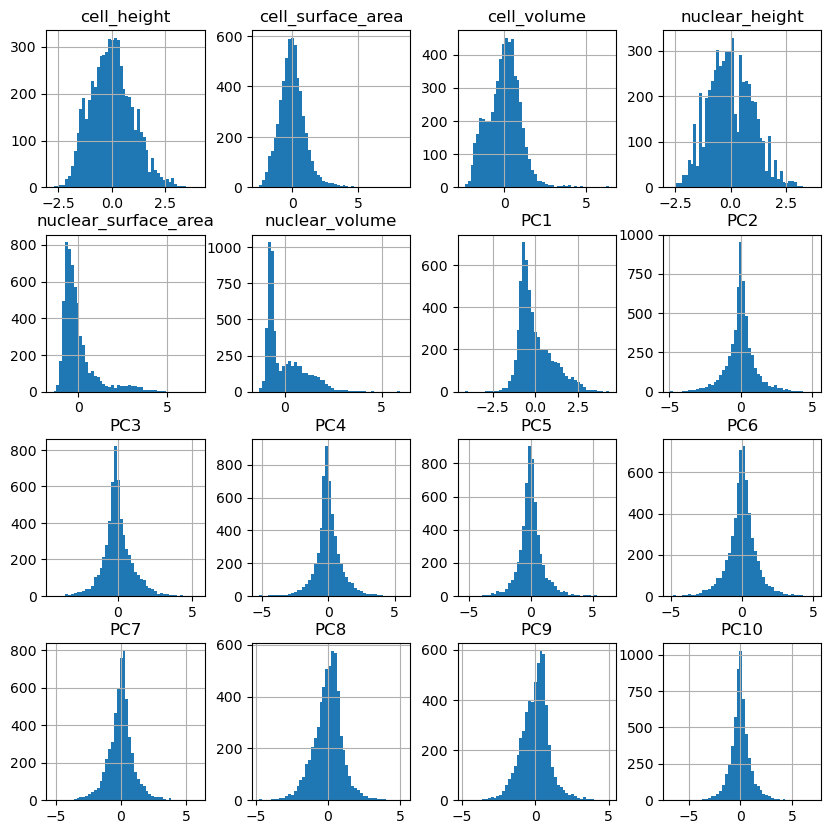

In [42]:
df_std.hist(bins=50, figsize=(10, 10));

In [43]:
reducer = umap.UMAP(random_state=0)
embedding = reducer.fit_transform(df_std)
embedding.shape

(5700, 2)

In [44]:
# For the visualization
marker = '.'
size_points = 10

In [45]:
y = df.loc[df_std.index, 'cell_stage']
import matplotlib.cm as cm

def make_colors(y, cmap_name='tab10', as_series=True):
    # make a cohort-wide cmap
    cmap = cm.get_cmap(cmap_name).colors
    # make color mapper
    # series to sort by decreasing order
    uniq = pd.Series(y).value_counts().index
    n_colors = len(cmap)
    labels_color_mapper = {x: cmap[i % n_colors] for i, x in enumerate(uniq)}
    # make list of colors
    labels_colors = [labels_color_mapper[x] for x in y]
    if as_series:
        labels_colors = pd.Series(labels_colors)
    return labels_colors


In [46]:
y.value_counts()

M0               1651
M4M5             1648
M1M2             1230
M6M7_complete     659
M3                512
Name: cell_stage, dtype: int64

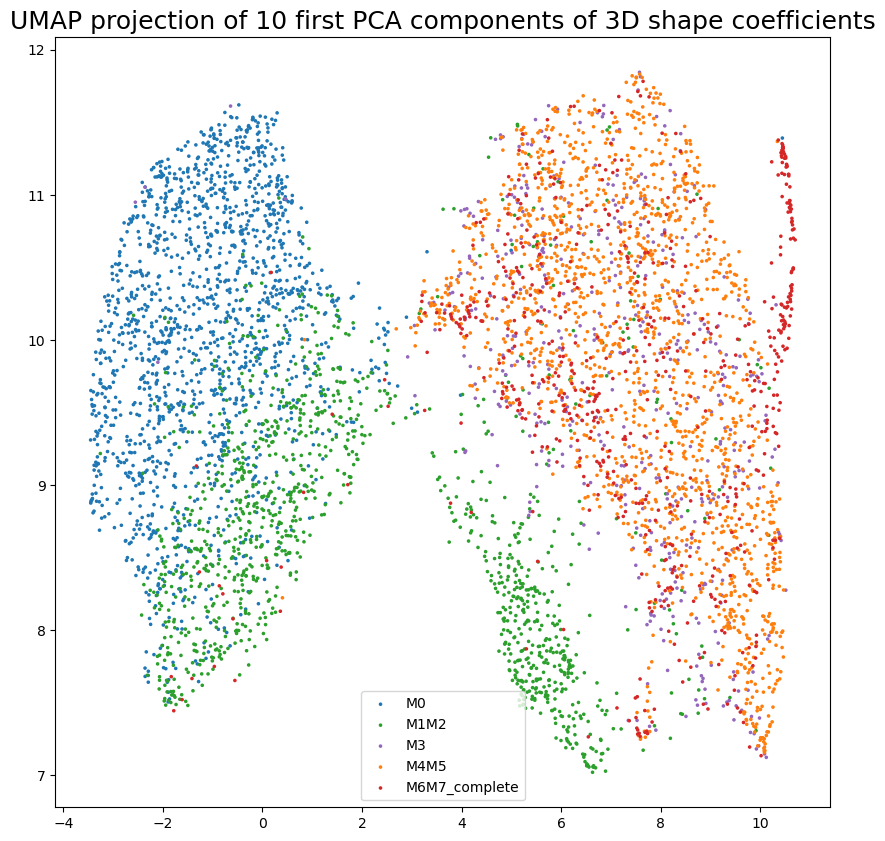

In [47]:
colors = make_colors(y, cmap_name='tab10')
fig, ax = plt.subplots(figsize=[10,10])
for y_class in np.unique(y):
    select = y.values == y_class
    ax.scatter(embedding[select, 0], embedding[select, 1], c=colors[select], marker=marker, s=size_points, label=y_class)
plt.legend()
title = "UMAP projection of 10 first PCA components of 3D shape coefficients"
plt.title(title, fontsize=18);